# Analisi Bibliometrica - Tesi Magistrale

Studente: Gianluca Renna - gianluca.renna@studio.unibo.it

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RGianluca14/analisi-bibliometrica/blob/main/analisi_bibliometrica.ipynb)


## Impostazioni preliminari
Clona il repository per accedere ai dati di input se l'esecuzione è su Colab

In [1]:
import os
import platform

try:
  import google.colab
  IN_COLAB = True
  
  if len(os.environ.get("COLAB_GPU", '')) > 0 and int(os.environ["COLAB_GPU"]) > 0:
    DEVICE = "cuda" # a GPU is connected
  else:
    DEVICE = "cpu" # No accelerator is connected
except:
  IN_COLAB = False
  if platform.system() == 'Darwin' and platform.machine() == 'arm64':
    DEVICE = "mps" # The code is running on a Mac with M1 or M2 processor
  else:
    DEVICE = "cpu" # No accelerator is connected

if IN_COLAB:
    if (os.getcwd() != '/content'):
        %cd ../../

    !git clone https://github.com/RGianluca14/analisi-bibliometrica.git
    %cd /content/analisi-bibliometrica/

Installa tutte le dipendenze e librerie necessarie

In [2]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 59.3 MB/s eta 0:00:00m eta 0:00:010:0101
  Preparing metadata (setup.py) ... done


Importa tutte le librerie

In [3]:
from sentence_transformers import SentenceTransformer
import umap
from wordcloud import WordCloud, STOPWORDS
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import xlsxwriter
import warnings
from sklearn.feature_extraction.text import CountVectorizer
import torch
import numpy as np
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance, KeyBERTInspired
spacy.load("en_core_web_sm")
warnings.filterwarnings("ignore")
seed = np.random.RandomState(42)

/Users/giuseppe.murro/miniconda3/envs/analisi-bibliometrica/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/y9/q6h4m5rj0vv77kk92lrzsr140000gq/T/ipykernel_47833/2013093763.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# 1. Data preprocessing

In [4]:
file_paths = [
    Path('').absolute() / "input" / "scopus_measurement.csv",
    Path('').absolute() / "input" / "scopus_innovationmetrics.csv",
    Path('').absolute() / "input" / "scopus_openinnovationmetrics.csv"
]

df_files = [pd.read_csv(file) for file in file_paths]

#unisci tutti i file csv
df_combined = pd.concat(df_files, ignore_index=True)

print(f"Numero di documenti: {len(df_combined)}")

Numero di documenti: 1177


In [5]:
# Ordina il DataFrame in base all'anno
df_combined = df_combined.sort_values(by='Year')

# Aggiunge una colonna normalizzata per verificare i duplicati
df_combined['normalized_title'] = df_combined['Title'].str.lower().str.strip()

# Elimina i duplicati mantenendo solo gli articoli più recenti
df_combined = df_combined.drop_duplicates(subset=['normalized_title'], keep='last')

# Rimuove la colonna aggiunta
df_combined = df_combined.drop(columns=['normalized_title'])
print(f"Numero finale di documenti: {len(df_combined)}")

# Rimozione delle colonne non desiderate
df_combined = df_combined.drop(columns=["Author full names", "Author(s) ID" ,"Source", "EID", "Open Access", "Publication Stage"])

# Traduzione dei titoli delle colonne in italiano
translations = {
    "Title": "Titolo",
    "Authors": "Autore/i",
    "Year": "Anno",
    "Source title": "Nome fonte del documento",
    "Document Type": "Tipo di documento",
    "DOI": "DOI",
    "Link": "Link",
    "Abstract": "Abstract",
    "Author Keywords": "Parole chiave dell'autore",
}
df_combined.rename(columns=translations, inplace=True)

# Specifica l'ordine desiderato delle colonne
ordered_columns = [
    "Titolo", "Autore/i", "Anno", "Abstract", "Parole chiave dell'autore",
    "Tipo di documento", "Nome fonte del documento", "Index Keywords"
]

# Aggiungi le colonne rimanenti che non sono state specificate esplicitamente
remaining_columns = [col for col in df_combined.columns if col not in ordered_columns]
final_column_order = ordered_columns + remaining_columns

# Riordina le colonne del DataFrame in base all'ordine specificato
df_combined = df_combined[final_column_order]

# Esportazione in un file Excel con formattazione
with pd.ExcelWriter("input/risultato_unione.xlsx", engine='xlsxwriter') as writer:
    df_combined.to_excel(writer, index=False, sheet_name='Database documenti scaricati')

    workbook = writer.book
    worksheet = writer.sheets['Database documenti scaricati']

    # Formattazione delle celle per il wrap text e il testo centrato
    cell_format = workbook.add_format({
        'text_wrap': True,
        'valign': 'vcenter',  # Centra verticalmente
        'align': 'center',    # Centra orizzontalmente
    })

    # Formattazione del titolo delle colonne con testo centrato
    header_format = workbook.add_format({
        'bold': True,
        'text_wrap': True,
        'valign': 'vcenter',
        'align': 'center',
        'fg_color': '#D7E4BC',  # Sfondo verde chiaro
        'border': 1
    })

# Applica la formattazione dell'intestazione alla prima riga
    for col_num, value in enumerate(df_combined.columns.values):
        worksheet.write(0, col_num, value, header_format)

    # Mappatura delle larghezze delle colonne specifiche
    column_widths = {
        "Abstract": 182,
        "Anno": 8.67,
        "Volume": 8.67,
        "Issue": 8.67,
        "Art. No.": 8.67,
        "Page start": 8.67,
        "Page end": 8.67,
        "Page count": 8.67,
        "Cited by": 8.67,
        "DOI": 38,
        "Link": 182
    }

    # Impostazione predefinita per tutte le altre colonne
    default_width = 26.33

    # Applica le larghezze specifiche alle colonne e la larghezza predefinita alle altre
    for col_num, column in enumerate(df_combined.columns):
        if column in column_widths:
            worksheet.set_column(col_num, col_num, column_widths[column], cell_format)
        else:
            worksheet.set_column(col_num, col_num, default_width, cell_format)

    # Imposta l'altezza delle righe (esclusa la prima) a 135 punti
    num_rows = len(df_combined)
    for row in range(1, num_rows + 1):
        worksheet.set_row(row, 135)  # Imposta l'altezza della riga a 135 punti

Numero finale di documenti: 1131


# 2. Bibliometric Analysis

In [6]:
#Lettura file contenente i documenti puliti e uniti
df = pd.read_excel('input/risultato_unione.xlsx')

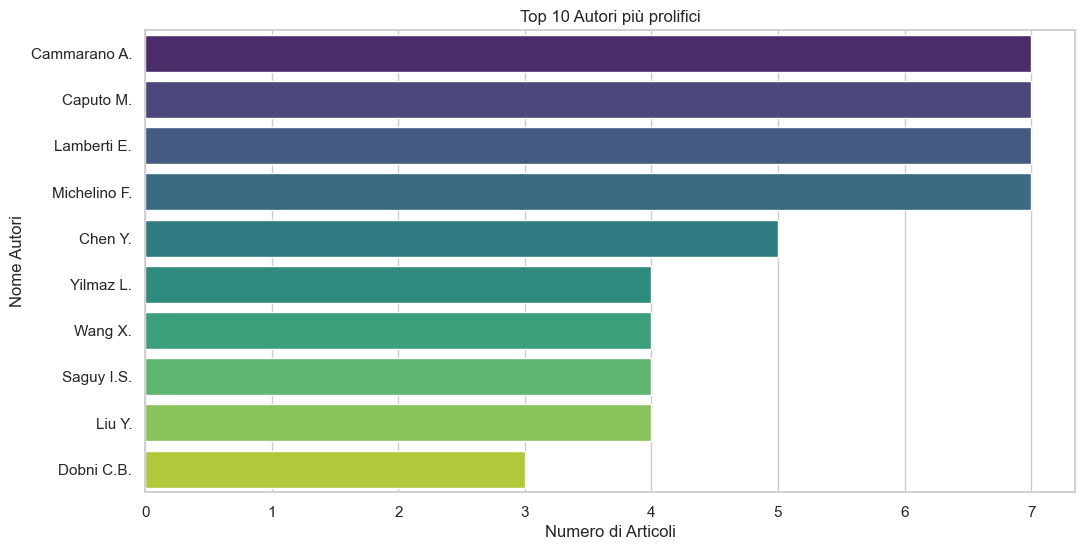

In [7]:
# Analisi autori più prolifici
prolific_authors = df['Autore/i'].str.split(';').explode().str.strip().value_counts().head(10)  # Top 10 autori

#print(f"Top 10 Autori più prolifici:\n{prolific_authors}")

# Opzioni stile
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Bar plot per autori piu prolifici
ax = sns.barplot(x=prolific_authors.values, y=prolific_authors.index, hue=prolific_authors.index, palette="viridis")
ax.set_title('Top 10 Autori più prolifici')
ax.set_xlabel('Numero di Articoli')
ax.set_ylabel('Nome Autori')
plt.show()

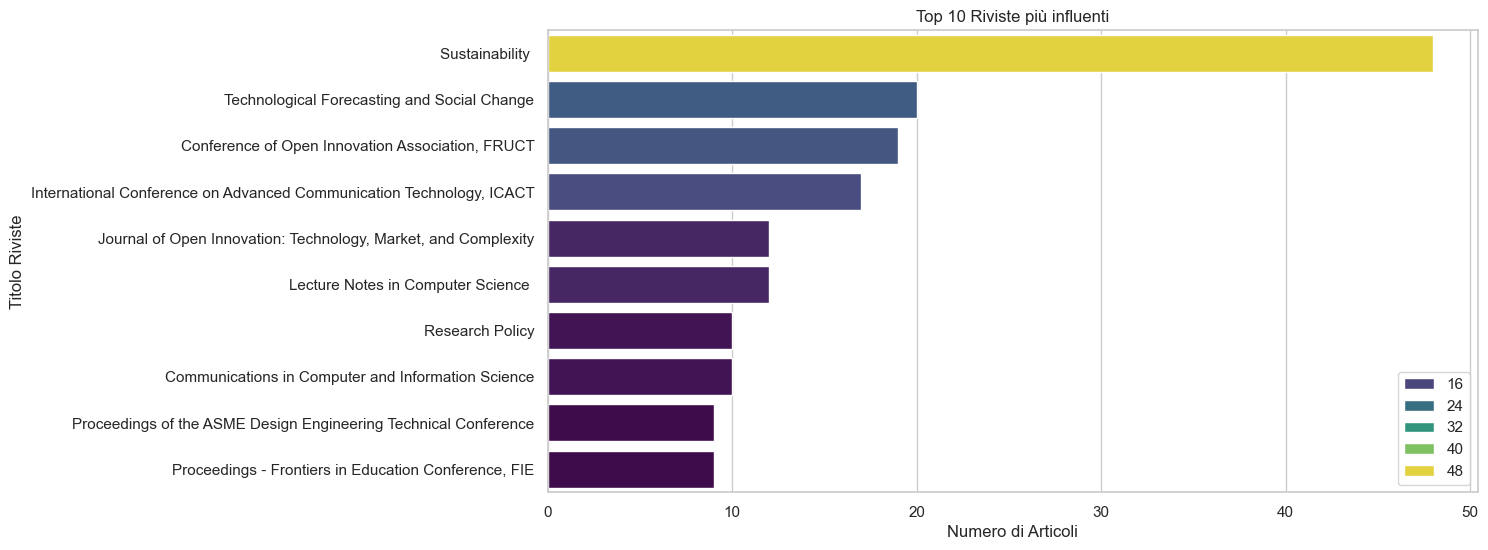

In [8]:
# Analisi riviste
influential_magazines = df['Nome fonte del documento'].value_counts().head(10)  # Top 10 riviste

#print(f"Top 10 Riviste più influenti:\n{influential_magazines}")

# Opzioni stile
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
colors = sns.color_palette("muted", len(influential_magazines))

# Bar plot per riviste più rilevanti
ax = sns.barplot(x=influential_magazines.values, y=influential_magazines.index.str.replace(r'\([^)]*\)', '', regex=True).values, hue=influential_magazines.values, palette="viridis")
ax.set_title('Top 10 Riviste più influenti')
ax.set_xlabel('Numero di Articoli')
ax.set_ylabel('Titolo Riviste')

plt.show()

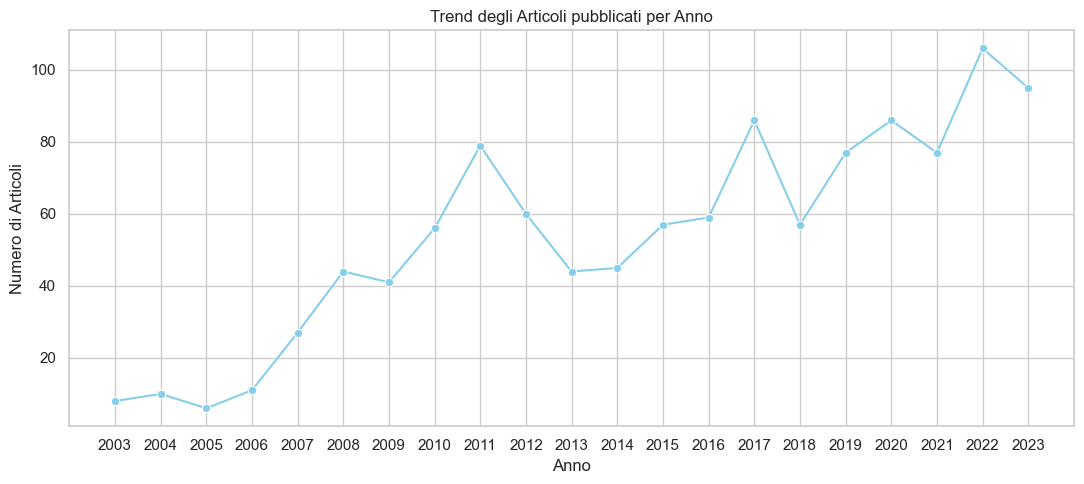

In [9]:
# Assuming your DataFrame is named df

# Convert 'Year' column to integer (if not already)
df['Anno'] = df['Anno'].astype(int)

# Trend over time (number of articles per year)
articles_per_year = df.groupby('Anno')['Titolo'].count()

# Trend over time (number of citations per year)
citations_per_year = df.groupby('Anno')['Cited by'].sum()

# Styling options
sns.set(style="whitegrid")

# Create subplots
plt.figure(figsize=(11, 5))

# Plotting the trend of articles
sns.lineplot(x=articles_per_year.index, y=articles_per_year.values, marker='o', color='skyblue')
plt.title('Trend degli Articoli pubblicati per Anno')
plt.xlabel('Anno')
plt.ylabel('Numero di Articoli')
plt.xticks(range(min(articles_per_year.index), max(articles_per_year.index)+1))


# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

# 3. Clustering

In [10]:
inputs = df['Titolo'] + "; " + df['Abstract']

In [11]:
# Caricamento del modello di incorporazione delle frasi
sentence_transformer_model_name = 'thenlper/gte-base'
model = SentenceTransformer(sentence_transformer_model_name)

In [12]:
# Conversione degli ingressi in incorporazioni vettoriali
embeddings = model.encode(inputs, show_progress_bar=True, device=DEVICE)

Batches: 100%|██████████| 36/36 [00:44<00:00,  1.25s/it]


In [13]:
# Forma delle incorporazioni (numero di paper, lunghezza del vettore)
print(f"Dimensione dei vettori prima della riduzione della dimensionalità: {embeddings.shape}")

# riduzione della dimensionalità a 2 dimensioni
umap_model = umap.UMAP(
    n_neighbors=18,
    min_dist=0.0,
    n_components=2,
    random_state=42,
)

umap_embeddings = umap_model.fit_transform(embeddings)

print(f"Dimensione dei vettori prima della riduzione della dimensionalità: {umap_embeddings.shape}")

Dimensione dei vettori prima della riduzione della dimensionalità: (1131, 768)
Dimensione dei vettori prima della riduzione della dimensionalità: (1131, 2)


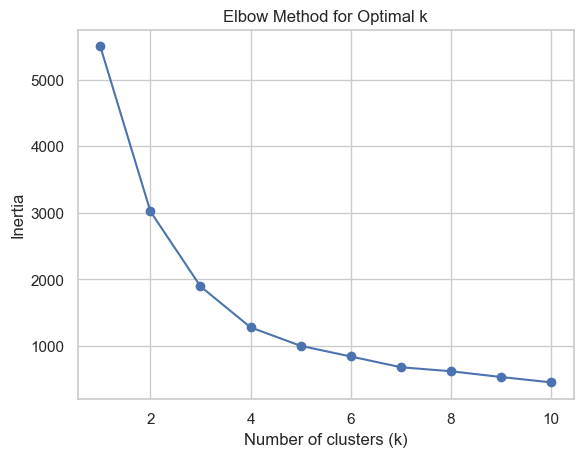

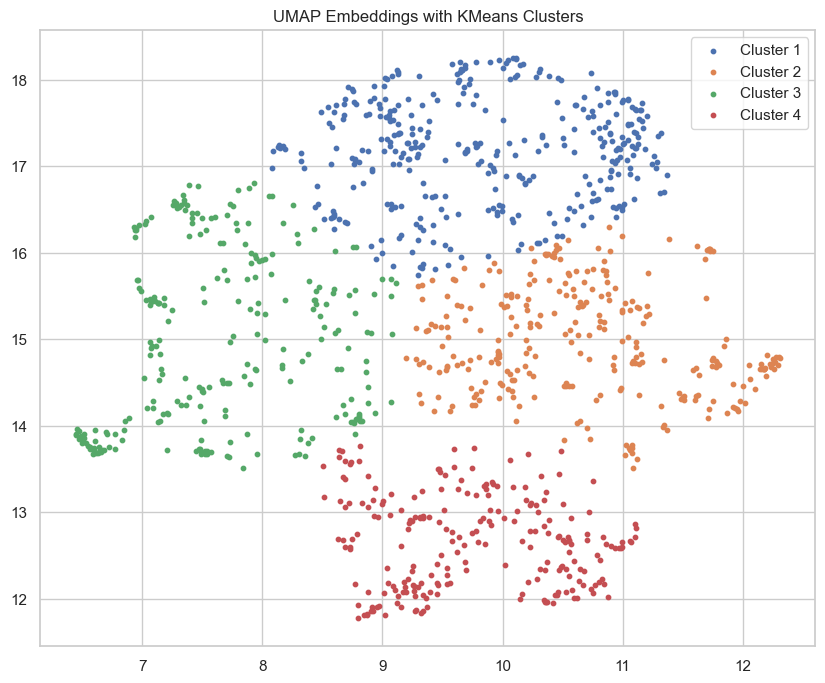

In [80]:
# Determine the optimal k for KMeans using the Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(umap_embeddings)
    inertia.append(kmeans.inertia_)

# Plot Elbow method
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Choose the best k based on the Elbow method
best_k = 4  # Update with the value you find from the Elbow method

# Apply KMeans clustering with the best k
kmeans = KMeans(n_clusters=best_k, random_state=42)
df['cluster'] = kmeans.fit_predict(umap_embeddings)

# reorder cluster id based on frequency and starting from 1
mapping = dict(zip(df['cluster'].value_counts().to_dict().keys() , [i for i in range(1, len(df['cluster'].value_counts())+1)]))
df['cluster'] = df['cluster'].map(mapping)

# Plot UMAP embeddings with cluster colors
plt.figure(figsize=(10, 8))
for cluster in range(1, best_k+1):
    cluster_data = df[df['cluster'] == cluster]
    plt.scatter(umap_embeddings[cluster_data.index, 0], umap_embeddings[cluster_data.index, 1],
                label=f'Cluster {cluster}', s=10)
plt.title('UMAP Embeddings with KMeans Clusters')
plt.legend()
plt.show()

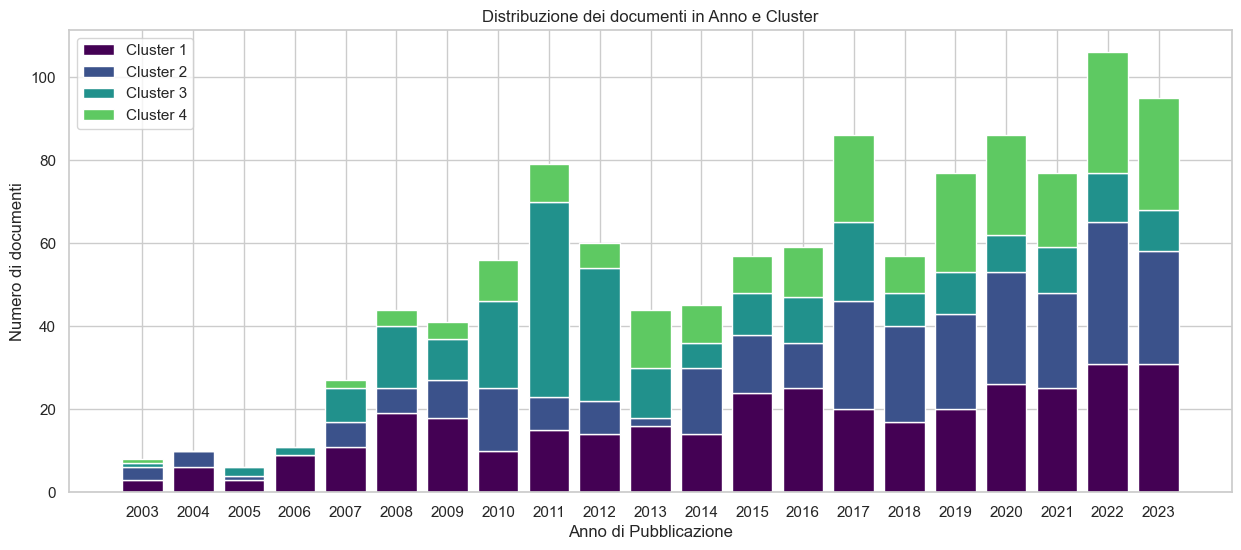

In [81]:
# Grafico aggiuntivo per anno di pubblicazione con colonne sovrapposte
cluster_colors = [plt.cm.viridis(i / best_k) for i in range(best_k)]

plt.figure(figsize=(15, 6))
year_counts = dict(zip(sorted(df['Anno'].unique()), np.zeros(len(df['Anno'].unique()))))

for cluster in range(1, best_k+1):
    cluster_data = df[df['cluster'] == cluster]
    year_counts_cluster = cluster_data['Anno'].value_counts().sort_index().to_dict()
    year_counts_cluster = {key: year_counts_cluster.get(key, 0)for key in year_counts.keys()}
    plt.bar(
      x=np.array(list(year_counts_cluster.keys())), 
      height=np.array(list(year_counts_cluster.values())), 
      color=cluster_colors[cluster-1], 
      label=f'Cluster {cluster}', 
      bottom=np.array(list(year_counts.values()))
    )
    for key, value in year_counts_cluster.items():
      year_counts[key] = year_counts[key] + value

plt.xlabel('Anno di Pubblicazione')
plt.ylabel('Numero di documenti')
plt.xticks(range(min(cluster_data['Anno']), max(cluster_data['Anno'])+1))
plt.title('Distribuzione dei documenti in Anno e Cluster')
plt.legend()
plt.show()

### Wordcloud including searching keywords
Searching word are those keywords used to get the list of papers: innovation, metrics, metric, open innovation, measurement, measurements

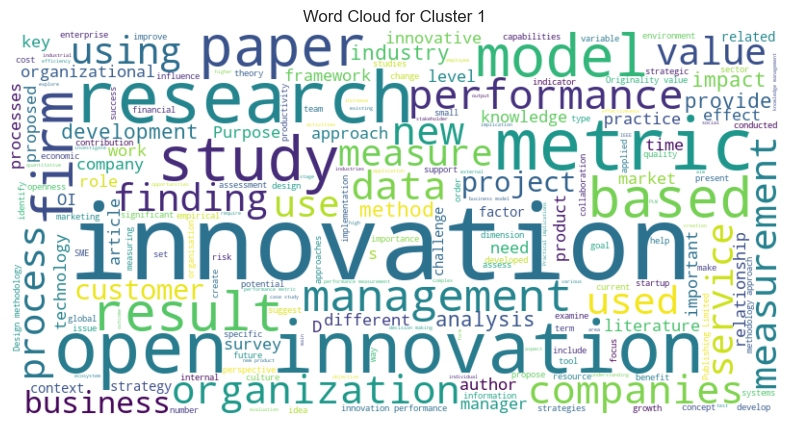

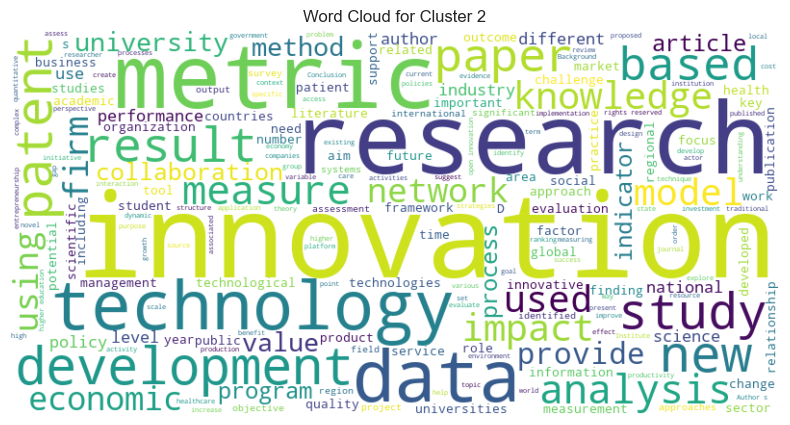

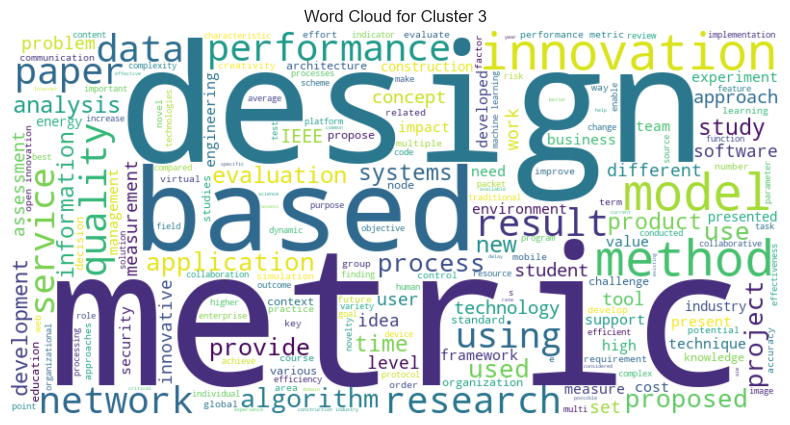

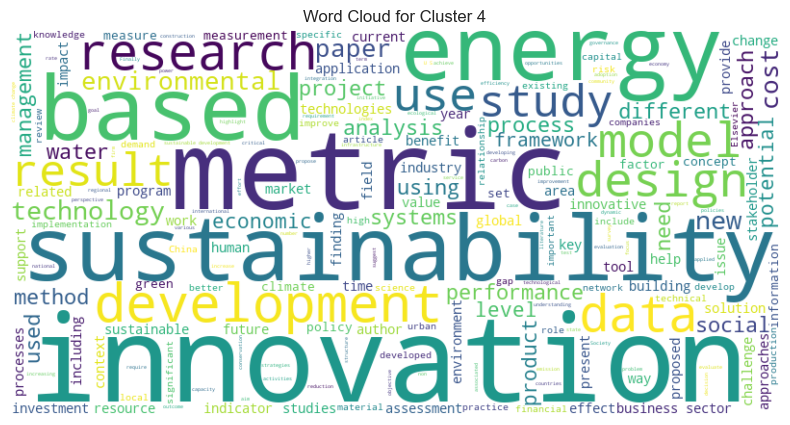

In [84]:
# Function to generate and display a word cloud for a given cluster
def generate_wordcloud(cluster_data, cluster_number):
    text = ' '.join(cluster_data['Abstract'].values)
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS.union(ENGLISH_STOP_WORDS)).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster_number}')
    plt.show()

# Generate and display word cloud for each cluster
for cluster in range(1, best_k+1):
    cluster_data = df[df['cluster'] == cluster]
    generate_wordcloud(cluster_data, cluster)

### Wordcloud removing searching keywords
Searching word are those keywords used to get the list of papers: innovation, metrics, metric, open innovation, measurement, measurements

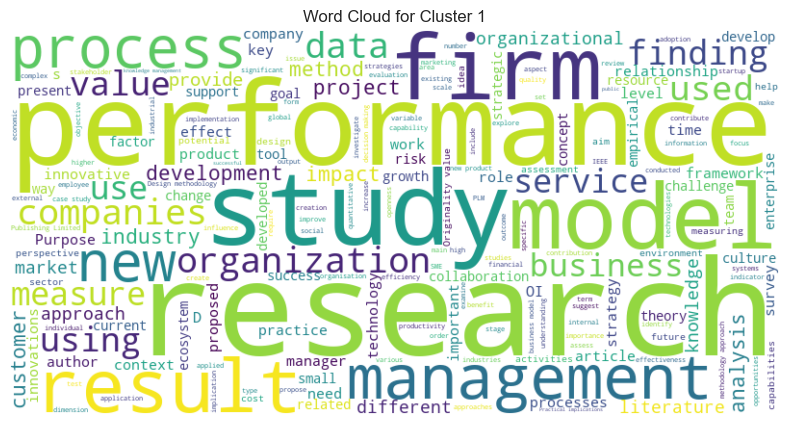

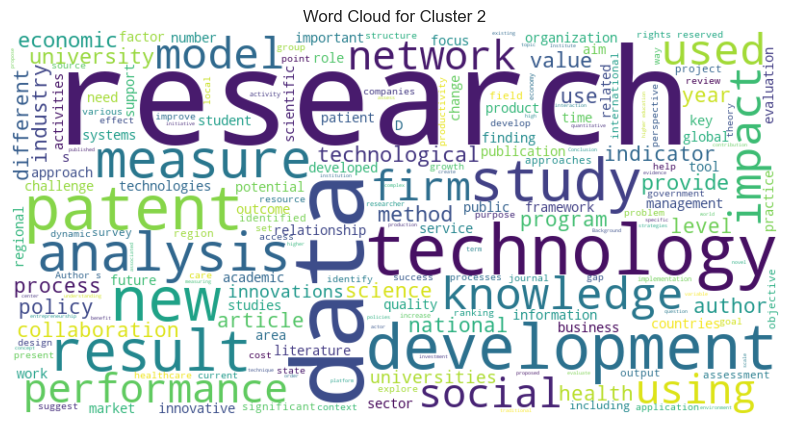

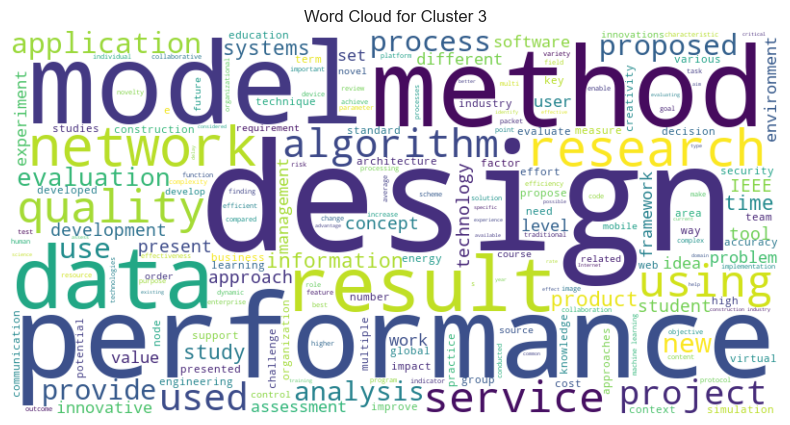

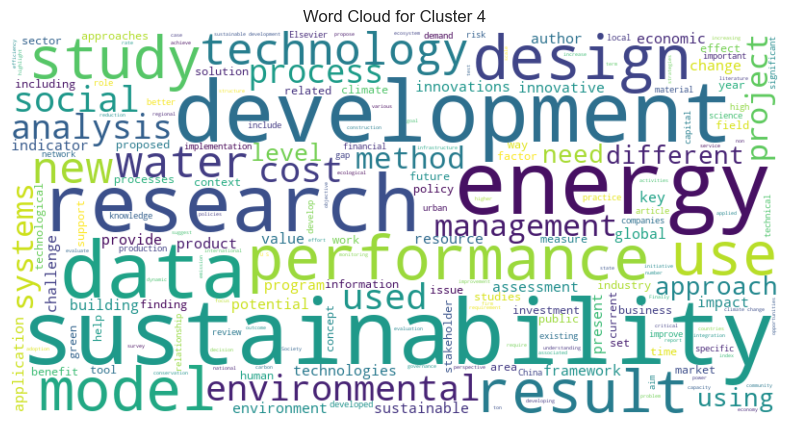

In [85]:
remove_words=STOPWORDS\
             .union(ENGLISH_STOP_WORDS) \
             .union({"innovation", "metrics", "metric", "open innovation", "open", "innovation", "measurement", "measurements"}) \
             .union({"based", "paper"})

# Function to generate and display a word cloud for a given cluster
def generate_wordcloud(cluster_data, cluster_number):
    text = ' '.join(cluster_data['Abstract'].values)
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=remove_words).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster_number}')
    plt.show()

# Generate and display word cloud for each cluster
for cluster in range(1, best_k+1):
    cluster_data = df[df['cluster'] == cluster]
    generate_wordcloud(cluster_data, cluster)

### Simalarity of papers based on specific words

In [88]:
target = "recycling and reuse"
target_embedding = model.encode(target, convert_to_tensor = True, device=DEVICE)
top_k = 10

# Calculate pairwise cosine similarity scores
similarities = torch.nn.CosineSimilarity(dim=1)
scores = similarities(target_embedding.unsqueeze(0), torch.Tensor(embeddings).to(device=DEVICE)).squeeze()

# Sort the similarity scores in descending order
sorted_indices = torch.argsort(scores, descending=True)[:top_k+1]

# Print the top K closest embeddings and their similarity scores
for idx in sorted_indices:
    print("Article {} has similarity score {:.4f}".format(idx, scores[idx]))
    print(f"Titolo: {df.iloc[idx.item()]['Titolo']}")
    print(f"Cluster: {df.iloc[idx.item()]['cluster']}")
    print()

Article 46 has similarity score 0.8403
Titolo: Eco-efficiency in primary metals production: Context, perspectives and methods
Cluster: 4

Article 742 has similarity score 0.8345
Titolo: Dematerialization and the Circular Economy: Comparing Strategies to Reduce Material Impacts of the Consumer Electronic Product Ecosystem
Cluster: 4

Article 193 has similarity score 0.8289
Titolo: Managing sustainability for the development of sustainable recycling technologies
Cluster: 4

Article 156 has similarity score 0.8283
Titolo: Incorporating cost and resource efficiency into the development of green recycling technologies
Cluster: 4

Article 555 has similarity score 0.8253
Titolo: A Metrics-Based Evaluation of Sustainable Manufacturing at Product and Process Levels
Cluster: 4

Article 1060 has similarity score 0.8248
Titolo: Waste as Resource for Pakistan: An Innovative Business Model of Regenerative Circular Economy to Integrate Municipal Solid Waste Management Sector
Cluster: 4

Article 211 h

### Topic Modelling
Inspired form https://towardsdatascience.com/topics-per-class-using-bertopic-252314f2640

More info about representation models here: https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#keybertinspired


Paper: https://arxiv.org/abs/2203.05794

In [143]:
main_representation_model = MaximalMarginalRelevance(diversity=.5)

representation_model = {
   "Main": main_representation_model,
}

vectorizer_model = CountVectorizer(min_df=2, stop_words = 'english')
topic_model = BERTopic(nr_topics = 'auto',
                      vectorizer_model = vectorizer_model,
                      representation_model = representation_model,
                      hdbscan_model=kmeans,
                      umap_model=umap_model)

topics, ini_probs = topic_model.fit_transform(inputs, embeddings=umap_embeddings, y=df['cluster'].to_numpy())

In [153]:
def add_authors_year_article(title, df):
    authors = df[df['Titolo'].str.startswith(title)].iloc[0]['Autore/i']
    year = df[df['Titolo'].str.startswith(title)].iloc[0]['Anno']
    return f"- Titolo: {title}\n"\
           f"- Autore/i: {authors}\n"\
           f"- Anno: {year}"

topic_stats = topic_model.get_topic_info()
topic_stats.drop(columns="Name", inplace=True)

# mantieni solo titoli
topic_stats['Representative_Docs'] = topic_stats['Representative_Docs'].apply(lambda x: [v.split(";")[0] for v in x ])

# formatta articoli aggiungendo anno e autori
topic_stats['Representative_Docs'] = topic_stats['Representative_Docs'].apply(lambda x: "\n\n".join([add_authors_year_article(title, df) for title in x]))

topic_stats['Topic'] = topic_stats['Topic'] +1

# rinomina colonne
topic_stats.rename(
    columns={
        'Topic' : 'Cluster'
        , 'Count' : 'Numero di articoli'
        , 'CustomName' : 'Nome cluster'
        , 'Representation' : "Argomenti"
        , 'Representative_Docs' : 'Articoli rappresentativi'
    },
    inplace=True
)

topic_stats

Cluster  Numero di articoli Nome cluster  \
0        1                 357            a   
1        2                 286            b   
2        3                 256            c   
3        4                 232            d   

                                           Argomenti  \
0  [innovation, open, performance, research, stud...   
1  [innovation, research, metrics, technology, da...   
2  [design, metrics, quality, performance, networ...   
3  [energy, sustainability, innovation, environme...   

                            Articoli rappresentativi  
0  - Titolo: Innovation intermediation at the new...  
1  - Titolo: Metrics-based profiling of universit...  
2  - Titolo: The potential of creativity metrics ...  
3  - Titolo: Metrics-based sustainability evaluat...

In [154]:
topic_model.visualize_barchart(n_words=10, custom_labels=True)

In [155]:
titles = [input.split(";")[0].strip() for input in inputs]
topic_model.visualize_documents(titles, reduced_embeddings=umap_embeddings, custom_labels=True)

In [168]:
hierarchical_topics = topic_model.hierarchical_topics(inputs)

# Print topic tree
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

100%|██████████| 3/3 [00:00<00:00, 313.80it/s]

.
├─■──design_metrics_quality_performance_network ── Topic: 2
└─innovation_research_metrics_performance_development
     ├─■──energy_sustainability_innovation_environmental_development ── Topic: 3
     └─innovation_research_open_metrics_performance
          ├─■──innovation_research_metrics_technology_data ── Topic: 1
          └─■──innovation_open_performance_research_study ── Topic: 0



### Salvataggio delle informazioni dei cluster in excel

In [158]:
# Esportazione in un file Excel con formattazione
with pd.ExcelWriter("output/clustered_papers.xlsx", engine='xlsxwriter') as writer:
    
    ### WRITE CLUSTERS SHEETS
    for i in range(1, best_k+1):
        df_filtered = df[df['cluster']==i][["Titolo", "Autore/i", "Anno", "Abstract", "Nome fonte del documento", "Tipo di documento", "DOI", "Link",  "Cited by"]]

        df_filtered.to_excel(writer, index=False, sheet_name=f'Cluster {i}')

        workbook = writer.book
        worksheet = writer.sheets[f'Cluster {i}']

        # Formattazione delle celle per il wrap text e il testo centrato
        cell_format = workbook.add_format({
            'text_wrap': True,
            'valign': 'vcenter',  # Centra verticalmente
            'align': 'center',    # Centra orizzontalmente
        })

        # Formattazione del titolo delle colonne con testo centrato
        header_format = workbook.add_format({
            'bold': True,
            'text_wrap': True,
            'valign': 'vcenter',
            'align': 'center',
            'fg_color': '#D7E4BC',  # Sfondo verde chiaro
            'border': 1
        })

        # Applica la formattazione dell'intestazione alla prima riga
        for col_num, value in enumerate(df_filtered.columns.values):
            worksheet.write(0, col_num, value, header_format)

        # Mappatura delle larghezze delle colonne specifiche
        column_widths = {
            "Abstract": 182,
            "Anno": 8.67,
            "Cited by": 8.67,
            "DOI": 38,
            "Link": 182
        }

        # Impostazione predefinita per tutte le altre colonne
        default_width = 26.33

        # Applica le larghezze specifiche alle colonne e la larghezza predefinita alle altre
        for col_num, column in enumerate(df_combined.columns):
            if column in column_widths:
                worksheet.set_column(col_num, col_num, column_widths[column], cell_format)
            else:
                worksheet.set_column(col_num, col_num, default_width, cell_format)

        # Imposta l'altezza delle righe (esclusa la prima) a 135 punti
        num_rows = len(df_combined)
        for row in range(1, num_rows + 1):
            worksheet.set_row(row, 135)  # Imposta l'altezza della riga a 135 punti
            
    ### WRITE TOPIC STATS SHEET
    topic_stats.to_excel(writer, index=False, sheet_name='Analisi argomenti')

    workbook = writer.book
    worksheet = writer.sheets['Analisi argomenti']
    
    # Formattazione delle celle per il wrap text e il testo centrato
    cell_format = workbook.add_format({
        'text_wrap': True,
        'valign': 'vcenter',  # Centra verticalmente
        'align': 'center',    # Centra orizzontalmente
    })

    # Formattazione del titolo delle colonne con testo centrato
    header_format = workbook.add_format({
        'bold': True,
        'text_wrap': True,
        'valign': 'vcenter',
        'align': 'center',
        'fg_color': '#D7E4BC',  # Sfondo verde chiaro
        'border': 1
    })


    # Applica la formattazione dell'intestazione alla prima riga
    for col_num, value in enumerate(topic_stats.columns.values):
        worksheet.write(0, col_num, value, header_format)

    # Mappatura delle larghezze delle colonne specifiche
    column_widths = {
        "Articoli rappresentativi": 182,
        "Cluster": 8.67,
        "Numero di articoli": 8.67,
        "Nome cluster": 28,
        "Argomenti": 60
    }

    # Impostazione predefinita per tutte le altre colonne
    default_width = 26.33

    # Applica le larghezze specifiche alle colonne e la larghezza predefinita alle altre
    for col_num, column in enumerate(topic_stats.columns):
        if column in column_widths:
            worksheet.set_column(col_num, col_num, column_widths[column], cell_format)
        else:
            worksheet.set_column(col_num, col_num, default_width, cell_format)

    # Imposta l'altezza delle righe (esclusa la prima) a 135 punti
    num_rows = len(topic_stats)
    for row in range(1, num_rows + 1):
        worksheet.set_row(row, 135)  # Imposta l'altezza della riga a 135 punti

Suggestion: Try with chatgpt to generate description and metrics from clusters, using those prompts (inspired from https://maartengr.github.io/BERTopic/getting_started/representation/llm.html#prompt-engineering):

In [181]:
topics = topic_model.get_topics()

In [190]:
df

Titolo  \
0     Heterarchies of Value in Manhattan-Based New M...   
1     How digital is communication in your organizat...   
2     R and D cluster quality measures and technolog...   
3     Construction of a systemic quality model for e...   
4     Integrating Technical and Management Decision ...   
...                                                 ...   
1126  Disruptive market shift: Conceptualization, an...   
1127  The role of radical innovation in circular str...   
1128  Measuring Innovation in Mauritius’ ICT Sector ...   
1129  How E-learning Is Correlated with Competitiven...   
1130  Factors that make open innovation more success...   

                                               Autore/i  Anno  \
0                                   Girard M.; Stark D.  2003   
1                           Tyrväinen P.; Päivärinta T.  2003   
2                               Watts R.J.; Porter A.L.  2003   
3                         Ortega M.; Pérez M.; Rojas T.  2003   
4               Lee C.; Powell A.; Murdoch J.; Clark G.  2003   
...                                                 ...   ...   
1126   Olabode O.E.; Hultman M.; Leonidou C.N.; Boso N.  2023   
1127                Arekrans J.; Ritzén S.; Laurenti R.  2023   
1128                  Böhmecke-Schwafert M.; Dörries C.  2023   
1129             Lopes G.A.; Furtado J.C.; Baierle I.C.  2023   
1130  Dencik J.; Fisher L.-G.; Higgins L.; Lipp A.; ...  2023   

                                               Abstract  \
0     This article develops a sociology of worth tha...   
1     Novel innovations in the area of digital media...   
2     "Innovation indicators" strive to track the ma...   
3     Quality is currently considered one of the mai...   
4     This paper explores the use of measurement to ...   
...                                                 ...   
1126  Although prior research has examined the effec...   
1127  Circular economy (CE) is gaining interest amon...   
1128  Measuring innovation accurately and efficientl...   
1129  E-learning has gained a prominent role in the ...   
1130  Purpose: Four management capabilities for succ...   

                              Parole chiave dell'autore Tipo di documento  \
0     collaboration; distributed intelligence; econo...           Article   
1     Categories of communication forms; CCF; Digita...  Conference paper   
2     Innovation indicators; R&D cluster quality mea...           Article   
3     Dromey's model; ISO 9126; Metrics; Quality mod...           Article   
4     Context-based Measurement (CbM); Management of...  Conference paper   
...                                                 ...               ...   
1126  Business model innovations; Disruptive market ...           Article   
1127  circular economy; innovation; management; radi...           Article   
1128  Developing countries; Emerging countries; ICT ...           Article   
1129  competitiveness; critical success factors; e-l...           Article   
1130  Ecosystem capability; Internal capability; Ope...           Article   

                               Nome fonte del documento  \
0                             Theory, Culture & Society   
1     ICEIS 2003 - Proceedings of the 5th Internatio...   
2           Technological Forecasting and Social Change   
3                              Software Quality Journal   
4     IEEE International Engineering Management Conf...   
...                                                 ...   
1126        Technological Forecasting and Social Change   
1127              Business Strategy and the Environment   
1128                   Journal of the Knowledge Economy   
1129                                 Education Sciences   
1130                            Strategy and Leadership   

                                         Index Keywords Volume Issue Art. No.  \
0                                                   NaN     20     3      NaN   
1     Digital storage; Investments; CCF; Communicati..

In [197]:
print("\n".join("- "+df[df['cluster']==i+1]['Abstract']))

- Novel innovations in the area of digital media are changing the ways we communicate and organize. However, few practical measures exist for analysing the digitalisation of organizational communication as an intermediate factor in the initiatives to adopt new information and communication technologies (ICT). Building upon the genre theory of organizational communication, a categorization of communication forms, and quantitative measures we suggest such metrics and a measurement method. A case study applying them in an industrial organization suggests the method and metrics to be applicable for quantifying how new information systems affect to organizational communication as well as for anticipating their digitalisation impact prior to the implementation. The metrics provide a basis for further work on analysing correlation between organizational performance and adoption of information and communication technology.
- This paper explores the use of measurement to support technical and m

Most representative documents

In [217]:
def get_prompt(documents: list[str], keywords: list[str]):
    nl = '\n'
    return "I have a topic that contains the following most representative documents:\n"\
    "```\n"\
    f"{nl.join('- ' + pd.Series(documents))}\n"\
    "```\n"\
    "The topic is described by the following keywords:\n"\
    f"`{', '.join(keywords)}`\n"\
    "Based on the information above, extract a short topic label in the following format:\n"\
    "topic: <topic label>"


topics = topic_model.get_topics()

for i, topic in topics.items():
    prompt = get_prompt(documents=topic_model.get_representative_docs(i), keywords=[t for t, _ in topic])
    print(f"Cluster {i+1}")
    print(prompt)
    print()

Cluster 1
I have a topic that contains the following most representative documents:
```
- Innovation intermediation at the new product development level: A case study in the bio-industrial sectors; This study investigates the performance of new innovation intermediaries in an open innovation framework. One promising way to open up the innovation process is to interact with innovation intermediaries either to find new co-development partners or to promote new technologies. However, the extensive literature dealing with open innovation needs to be enriched by studies highlighting the role of new innovation intermediaries at the new product development (NPD) level. To do so, this paper presents a concrete technological case study to illustrate the mechanism of innovation intermediaries in promoting under-development technologies. A qualitative research approach was used to analyse the performance of classical innovation consulting approaches when compared with web-based intermediaries als

All documents

In [237]:
def get_prompt(documents: list[str], keywords: list[str]):
    nl = '\n'
    return "I have a topic that contains the following most representative documents:\n"\
    "```\n"\
    f"{nl.join('- ' + pd.Series(documents))}\n"\
    "```\n"\
    "The topic is described by the following keywords:\n"\
    f"`{', '.join(keywords)}`\n"\
    "Based on the information above, extract a short topic label in the following format:\n"\
    "topic: <topic label>\n\n"\
    "The output should be translated in italian"
    


topics = topic_model.get_topics()

for i, topic in topics.items():
    # concatena autore, anno, titolo e abstract
    documents = df[df['cluster']==i+1]['Autore/i'].fillna('')  + " (" + df[df['cluster']==i+1]['Anno'].fillna('').astype(str) + "); " + df[df['cluster']==i+1]['Titolo'].fillna('') + "; " + df[df['cluster']==i+1]['Abstract'].fillna('')
    prompt = get_prompt(documents=documents, keywords=[t for t, _ in topic])
    print(f"Cluster {i+1}")
    print(prompt)
    print()
    print()
    print()

Cluster 1
I have a topic that contains the following most representative documents:
```
- Tyrväinen P.; Päivärinta T. (2003); How digital is communication in your organization? A metrics and an analysis method; Novel innovations in the area of digital media are changing the ways we communicate and organize. However, few practical measures exist for analysing the digitalisation of organizational communication as an intermediate factor in the initiatives to adopt new information and communication technologies (ICT). Building upon the genre theory of organizational communication, a categorization of communication forms, and quantitative measures we suggest such metrics and a measurement method. A case study applying them in an industrial organization suggests the method and metrics to be applicable for quantifying how new information systems affect to organizational communication as well as for anticipating their digitalisation impact prior to the implementation. The metrics provide a bas